In [4]:
from advisor_backend.interface import Interface
import matplotlib.pyplot as plt
import numpy as np

# 集群调优分析
## 1. 集群分析的数据准备
首先我们当前支持PyTorch多卡大模型的集群分析，您需要输入集群分析的profiling_path路径，例如：
--{profiling_path}
    -- xxxx_ascend_pt
    -- xxxx_ascend_pt
    -- xxxx_ascend_pt
    ......
    -- xxxx_ascend_pt
里面每张卡的profiling文件都是ascend_pt结尾的文件。

## 2. 集群分析解决的问题
当前的功能主要有三项：
1）. 识别多卡间的计算慢卡（根据计算时间等推断）
2）. 识别多卡间的通信慢现象（根据通信链路的带宽判断）
3）. 对多卡间的计算算子进行统计展示（识别不同卡的算子差异）

In [5]:
# EDIT THE PROFILING DATA PATH
cluster_path = "YOUR PATH"
interface = Interface(cluster_path)

## 1) 识别慢卡

In [10]:
dataset = interface.get_data('cluster', 'slow rank')


[INFO]Cluster has been analyzed because of the existence of cluster analysis output directory.
[INFO]Skip Cluster analyze backend.


In [15]:
# EDIT THE DATA TO SHOW WHAT YOU WANT
data = dataset.get('data')
words = dataset.get('bottleneck')
rank_ids = list(data.keys())
# 柱状图显示属性
compute_time = [data.get(key, {})[0] for key in rank_ids]
communication_time = [data.get(key, {})[1] for key in rank_ids]
free_time = [data.get(key, {})[2] for key in rank_ids]
# 柱宽
width = 0.2



Communication has some issues in the cluster, because the max difference of Communication time has reached 88.476ms. 
Free has some issues in the cluster, because the max difference of Free time has reached 29.224ms. 



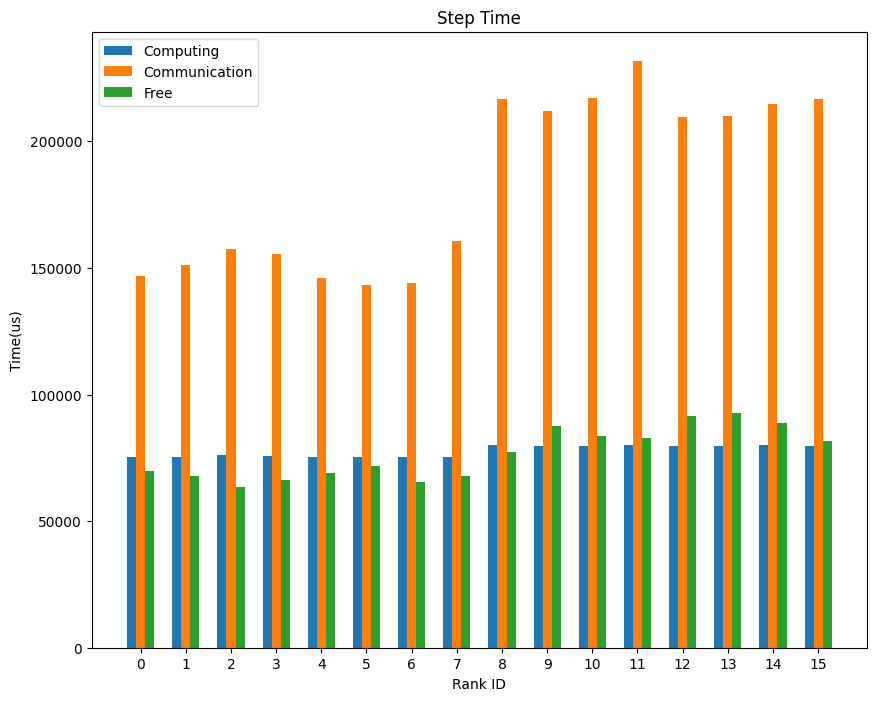

In [16]:
# 设置展示图大小
fig, ax = plt.subplots(figsize=(10,8))

x = np.arange(len(rank_ids)) # the label locations

rects1 = ax.bar(x - width, compute_time, width, label='Computing')
rects2 = ax.bar(x, communication_time, width, label='Communication')
rects3 = ax.bar(x + width, free_time, width, label='Free')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time(us)')
ax.set_xlabel('Rank ID')
ax.set_title('Step Time')
ax.set_xticks(x)
ax.set_xticklabels(rank_ids)
ax.legend()
print(words)

## 2）识别通信链路慢

In [6]:
dataset = interface.get_data('cluster', 'slow link')

[INFO]Cluster has been analyzed because of the existence of cluster analysis output directory.
[INFO]Skip Cluster analyze backend.


In [14]:
# EDIT THE DATA TO SHOW WHAT YOU WANT
data = dataset.get('data')
words = dataset.get('bottleneck')
rank_ids = list(data.keys())
# 柱状图显示属性
sdma_bw = [data.get(key, {}).get("SDMA bandwidth(GB/s)") for key in rank_ids]
rdma_bw = [data.get(key, {}).get("RDMA bandwidth(GB/s)") for key in rank_ids]
# 柱宽
width = 0.4

RDMA bandwidth(GB/s): 
The average is 0.041, while the maximum  is 0.041GB/s and the minimum is 0.041GB/s. the difference is 0.0GB/s. 
SDMA bandwidth(GB/s): 
The average is 0.054, while the maximum  is 0.056GB/s and the minimum is 0.052GB/s. the difference is 0.003GB/s. 



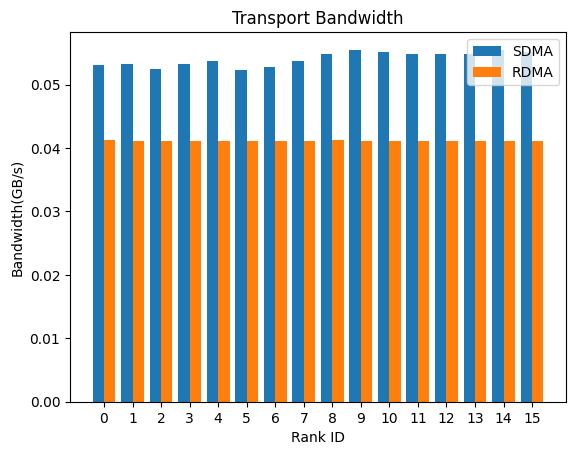

In [15]:
# 设置展示图大小
fig, ax = plt.subplots(figsize=(10,8))

x = np.arange(len(rank_ids)) # the label locations

rects1 = ax.bar(x - width/2, sdma_bw, width, label='SDMA')
rects2 = ax.bar(x + width/2, rdma_bw, width, label='RDMA')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Bandwidth(GB/s)')
ax.set_xlabel('Rank ID')
ax.set_title('Transport Bandwidth')
ax.set_xticks(x)
ax.set_xticklabels(rank_ids)
ax.legend()
print(words)

In [13]:
print(dataset.get('bottleneck'))

RDMA bandwidth(GB/s): 
The average is 0.041, while the maximum  is 0.041GB/s and the minimum is 0.041GB/s. the difference is 0.0GB/s. 
SDMA bandwidth(GB/s): 
The average is 0.054, while the maximum  is 0.056GB/s and the minimum is 0.052GB/s. the difference is 0.003GB/s. 



## 3) 分布式卡上的kernel算子统计展示

In [11]:
dataset = interface.get_data('cluster', 'kernel')

In [12]:
dataset

,rank id,Name,Input Shapes,Input Data Types,Output Shapes,Duration(us)_mean,Duration(us)_var,Duration(us)_max,Duration(us)_min,Duration(us)_count,Duration(us)_sum
0,0,Add,"""1024,2,5120;1024,2,5120""",DT_BF16;DT_BF16,"""1024,2,5120""",45.012050,82.952748,55.9255,35.3108,16,720.1928
1,0,Add,"""2,8192,5120;2,8192,5120""",DT_BF16;DT_BF16,"""2,8192,5120""",447.183700,NaN,447.1837,447.1837,1,447.1837
2,0,Add,"""8192,2,1920;1920""",DT_BF16;DT_BF16,"""8192,2,1920""",54.330850,1.342846,55.2456,52.6463,4,217.3234
3,0,Add,"""8192,2,2560;2560""",DT_BF16;DT_BF16,"""8192,2,2560""",75.485375,0.761315,76.2802,74.2407,4,301.9415
4,0,Add,""";""",FLOAT;FLOAT,"""""",1.200884,0.017257,1.4996,0.9597,50,60.0442
...,...,...,...,...,...,...,...,...,...,...,...
1441,15,atomic_memset-1_67_1998432_1_0,"""""",UNDEFINED,"""""",3.160000,NaN,3.1600,3.1600,1,3.1600
1442,15,trans_Cast_14,"""1""",FLOAT,"""1""",1.390000,0.023067,1.6000,1.2600,4,5.5600
1443,15,trans_Cast_15,"""""",INT32,"""""",64.445000,36.276100,70.3000,59.2000,4,257.7800
1444,15,trans_Cast_4,"""1""",FLOAT,"""1""",1.555000,0.035857,1.9400,1.3200,8,12.4400


In [5]:
# 保存到csv查看， 可修改保存路径
dataset.to_csv('cluster_kernel_details.csv', index=False, sep='\t')